#### Loading the noshowappointments dataset from Kaggle and loading it onto a Pandas dataframe

In [1]:
import kagglehub
path = kagglehub.dataset_download("joniarroba/noshowappointments")
print("path to dataset files -> {}".format(path))

path to dataset files -> C:\Users\Admin\.cache\kagglehub\datasets\joniarroba\noshowappointments\versions\5


In [2]:
import os
print(os.listdir(path))

['KaggleV2-May-2016.csv']


In [3]:
import pandas as pd
files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]
fullpath = os.path.join(path, csv_file)
noshow_dataset_df = pd.read_csv(fullpath)

#### Data exploratrion

In [4]:
noshow_dataset_df.head(4)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No


In [5]:
noshow_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [6]:
noshow_dataset_df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


#### Removal of features than cannot affect the outcome(i.e., whether the patient is a no show) in any way

In [7]:
noshow_dataset_df1 = noshow_dataset_df.drop(['PatientId', 'AppointmentID'], axis=1)

In [8]:
noshow_dataset_df1.describe()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [9]:
noshow_dataset_df1.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [10]:
noshow_dataset_df1.tail(100)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
110427,F,2016-06-02T09:46:11Z,2016-06-08T00:00:00Z,56,RESISTÊNCIA,0,0,0,0,0,1,No
110428,F,2016-06-03T12:33:46Z,2016-06-08T00:00:00Z,8,RESISTÊNCIA,0,0,0,0,0,1,Yes
110429,F,2016-06-07T10:12:25Z,2016-06-08T00:00:00Z,44,RESISTÊNCIA,0,0,0,0,0,0,Yes
110430,F,2016-05-25T09:01:33Z,2016-06-01T00:00:00Z,57,RESISTÊNCIA,0,0,0,0,0,0,Yes
110431,M,2016-06-03T08:45:25Z,2016-06-08T00:00:00Z,12,RESISTÊNCIA,0,0,0,0,0,1,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
110522,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


## converting all the columns to numeric datatypes

male values denoted by 'M' in the Gender column are encoded as 0 and female → 'F' encoded as 1

In [11]:
noshow_dataset_df1['Gender'] = noshow_dataset_df1['Gender'].apply(lambda x: 1 if x == 'F' else 0)

In [12]:
noshow_dataset_df1.keys()

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show'],
      dtype='object')

Encoding of the No-show column:
 'Yes' encoded as 1
 'No' encoded as 0

In [13]:
noshow_dataset_df1['No-show'] = noshow_dataset_df1['No-show'].apply(lambda x: 1 if x == 'Yes' else 0)

In [14]:
noshow_dataset_df1.describe()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,0.649977,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933
std,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


In [15]:
noshow_dataset_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Gender          110527 non-null  int64 
 1   ScheduledDay    110527 non-null  object
 2   AppointmentDay  110527 non-null  object
 3   Age             110527 non-null  int64 
 4   Neighbourhood   110527 non-null  object
 5   Scholarship     110527 non-null  int64 
 6   Hipertension    110527 non-null  int64 
 7   Diabetes        110527 non-null  int64 
 8   Alcoholism      110527 non-null  int64 
 9   Handcap         110527 non-null  int64 
 10  SMS_received    110527 non-null  int64 
 11  No-show         110527 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 10.1+ MB


In [16]:
noshow_dataset_df1[['ScheduledDay', 'AppointmentDay']].tail(100)

,ScheduledDay,AppointmentDay
110427,2016-06-02T09:46:11Z,2016-06-08T00:00:00Z
110428,2016-06-03T12:33:46Z,2016-06-08T00:00:00Z
110429,2016-06-07T10:12:25Z,2016-06-08T00:00:00Z
110430,2016-05-25T09:01:33Z,2016-06-01T00:00:00Z
110431,2016-06-03T08:45:25Z,2016-06-08T00:00:00Z
...,...,...
110522,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z
110523,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z
110524,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z
110525,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z


## Feature engineering

In the cell below, the duration, in days, between schedule day and appointment day is derived and stored in a column

In [17]:
noshow_dataset_df1[['AppointmentDay', 'ScheduledDay']] = noshow_dataset_df1[['AppointmentDay', 'ScheduledDay']].apply(pd.to_datetime)
noshow_dataset_df1['WaitingDays'] = (noshow_dataset_df1['AppointmentDay'] - noshow_dataset_df1['ScheduledDay']).dt.days

In [18]:
noshow_dataset_df1['WaitingDays'].head(10000)

0      -1
1      -1
2      -1
3      -1
4      -1
       ..
9995   -1
9996   -1
9997    5
9998    5
9999    5
Name: WaitingDays, Length: 10000, dtype: int64

In [19]:
negative_wait = noshow_dataset_df1[noshow_dataset_df1['WaitingDays'] < 0]
print(f"Records with negative waiting time: {len(negative_wait)}")
print(f"Percentage of total: {len(negative_wait)/len(noshow_dataset_df1)*100:.2f}%")

Records with negative waiting time: 38568
Percentage of total: 34.89%


In [20]:
noshow_dataset_df1[noshow_dataset_df1['WaitingDays'] == -1].sample(n=10, replace=True)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingDays
40301,1,2016-05-10 08:49:59+00:00,2016-05-10 00:00:00+00:00,69,JOANA D´ARC,0,0,0,0,0,0,0,-1
2894,0,2016-04-29 12:35:57+00:00,2016-04-29 00:00:00+00:00,36,ILHA DE SANTA MARIA,1,0,0,0,0,0,0,-1
110464,1,2016-06-03 07:42:27+00:00,2016-06-03 00:00:00+00:00,53,RESISTÊNCIA,0,0,0,0,0,0,0,-1
107261,1,2016-06-08 07:27:38+00:00,2016-06-08 00:00:00+00:00,51,ILHA DE SANTA MARIA,0,0,0,0,0,0,0,-1
35704,1,2016-05-04 15:03:14+00:00,2016-05-04 00:00:00+00:00,25,ITARARÉ,0,0,0,0,0,0,0,-1
717,0,2016-04-29 09:40:35+00:00,2016-04-29 00:00:00+00:00,28,ROMÃO,0,0,0,0,0,0,0,-1
11123,1,2016-05-24 12:48:54+00:00,2016-05-24 00:00:00+00:00,53,RESISTÊNCIA,0,1,1,0,0,0,0,-1
76489,0,2016-05-10 07:39:53+00:00,2016-05-10 00:00:00+00:00,4,ARIOVALDO FAVALESSA,1,0,0,0,0,0,0,-1
103581,1,2016-06-08 08:46:18+00:00,2016-06-08 00:00:00+00:00,30,JESUS DE NAZARETH,0,0,0,0,0,0,0,-1
70242,1,2016-05-31 07:31:25+00:00,2016-05-31 00:00:00+00:00,14,GRANDE VITÓRIA,1,0,0,0,0,0,1,-1


In [21]:
noshow_dataset_df1[(noshow_dataset_df1['WaitingDays'] == -1) & (noshow_dataset_df1['No-show'] == 1)].sample(n=5)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingDays
51071,0,2016-05-03 14:02:53+00:00,2016-05-03 00:00:00+00:00,10,JESUS DE NAZARETH,0,0,0,0,0,0,1,-1
16587,1,2016-05-11 10:53:25+00:00,2016-05-11 00:00:00+00:00,21,MARIA ORTIZ,0,0,0,0,0,0,1,-1
101913,0,2016-06-07 11:10:22+00:00,2016-06-07 00:00:00+00:00,84,RESISTÊNCIA,0,1,0,0,2,0,1,-1
81130,1,2016-05-18 09:56:25+00:00,2016-05-18 00:00:00+00:00,41,BONFIM,1,0,0,0,0,0,1,-1
72904,0,2016-05-18 13:21:30+00:00,2016-05-18 00:00:00+00:00,51,ANDORINHAS,0,1,1,0,0,0,1,-1


In [22]:
print(len(noshow_dataset_df[(noshow_dataset_df1['WaitingDays'] == -1) & (noshow_dataset_df1['No-show'] == 1)])/ len(negative_wait) * 100)

4.646338933831156


some statistics,
    37% of records show negative waiting times
    of that 4% are no show appointments
conclusion:
    initially thought negative waiting times are a proxy for walk-in appointments, however, 4% no show subset disproves this, and
    now it is assumed that they are errors in data collections.

### issuing an integer id for each unique neighborhood

In [23]:
print(noshow_dataset_df1['Neighbourhood'].nunique())

81


80 unique neighborhoods to be converted into 80 integer ids

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
noshow_dataset_df1['Neighbourhood'] = le.fit_transform(noshow_dataset_df1['Neighbourhood'])
print("Neighbourhood lookup table:\n")
for i,class_name in enumerate(le.classes_):
    print("ID: {}, Neighborhood name: {}".format(i, class_name))

Neighbourhood lookup table:

ID: 0, Neighborhood name: AEROPORTO
ID: 1, Neighborhood name: ANDORINHAS
ID: 2, Neighborhood name: ANTÔNIO HONÓRIO
ID: 3, Neighborhood name: ARIOVALDO FAVALESSA
ID: 4, Neighborhood name: BARRO VERMELHO
ID: 5, Neighborhood name: BELA VISTA
ID: 6, Neighborhood name: BENTO FERREIRA
ID: 7, Neighborhood name: BOA VISTA
ID: 8, Neighborhood name: BONFIM
ID: 9, Neighborhood name: CARATOÍRA
ID: 10, Neighborhood name: CENTRO
ID: 11, Neighborhood name: COMDUSA
ID: 12, Neighborhood name: CONQUISTA
ID: 13, Neighborhood name: CONSOLAÇÃO
ID: 14, Neighborhood name: CRUZAMENTO
ID: 15, Neighborhood name: DA PENHA
ID: 16, Neighborhood name: DE LOURDES
ID: 17, Neighborhood name: DO CABRAL
ID: 18, Neighborhood name: DO MOSCOSO
ID: 19, Neighborhood name: DO QUADRO
ID: 20, Neighborhood name: ENSEADA DO SUÁ
ID: 21, Neighborhood name: ESTRELINHA
ID: 22, Neighborhood name: FONTE GRANDE
ID: 23, Neighborhood name: FORTE SÃO JOÃO
ID: 24, Neighborhood name: FRADINHOS
ID: 25, Neighborhoo

In [25]:
noshow_dataset_df1.head(5)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingDays
0,1,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,39,0,1,0,0,0,0,0,-1
1,0,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,39,0,0,0,0,0,0,0,-1
2,1,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,45,0,0,0,0,0,0,0,-1
3,1,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,54,0,0,0,0,0,0,0,-1
4,1,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,39,0,1,1,0,0,0,0,-1


extracting the day of the week and month for the appointment

In [26]:
noshow_dataset_df1['appointment_day_of_week'] = noshow_dataset_df1['AppointmentDay'].dt.day_name()
noshow_dataset_df1['appointment_month'] = noshow_dataset_df1['AppointmentDay'].dt.month

encoding the day of the week

In [27]:
# For KNN, you might want numerical encoding
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
               'Friday': 4, 'Saturday': 5, 'Sunday': 6}
noshow_dataset_df1['day_of_week_encoded'] = noshow_dataset_df1['appointment_day_of_week'].map(day_mapping)

In [28]:
noshow_dataset_df1['appointment_month'].sample(10000)

61427    5
72932    5
22371    5
6538     5
80422    5
        ..
25160    5
30261    5
89557    6
59053    5
52867    5
Name: appointment_month, Length: 10000, dtype: int32

In [29]:
noshow_dataset_df1[['appointment_month','AppointmentDay']].sample(20)

,appointment_month,AppointmentDay
55358,5,2016-05-12 00:00:00+00:00
31427,5,2016-05-04 00:00:00+00:00
72960,5,2016-05-20 00:00:00+00:00
29107,5,2016-05-12 00:00:00+00:00
84045,5,2016-05-30 00:00:00+00:00
102493,6,2016-06-07 00:00:00+00:00
104631,6,2016-06-06 00:00:00+00:00
58192,5,2016-05-03 00:00:00+00:00
96379,6,2016-06-01 00:00:00+00:00
93719,6,2016-06-07 00:00:00+00:00


### adding the hypertension vs age feature interaction

In [30]:
noshow_dataset_df1["age_hypertension_interraction"] = noshow_dataset_df1["Age"] * noshow_dataset_df1["Hipertension"]

creating a feature for if the appointment day is a weekend

In [31]:
noshow_dataset_df1["is_weekend"] = noshow_dataset_df1["day_of_week_encoded"].apply(lambda x: 1 if (x == 5) or (x == 6) else 0)

In [32]:
noshow_dataset_df1[noshow_dataset_df1["is_weekend"] == 1].count()

Gender                           39
ScheduledDay                     39
AppointmentDay                   39
Age                              39
Neighbourhood                    39
Scholarship                      39
Hipertension                     39
Diabetes                         39
Alcoholism                       39
Handcap                          39
SMS_received                     39
No-show                          39
WaitingDays                      39
appointment_day_of_week          39
appointment_month                39
day_of_week_encoded              39
age_hypertension_interraction    39
is_weekend                       39
dtype: int64

adding is_Friday boolean feature to the data

In [33]:
noshow_dataset_df1["is_friday"] = noshow_dataset_df1["day_of_week_encoded"].apply(lambda x: 1 if x == 4 else 0)
noshow_dataset_df1[(noshow_dataset_df1["is_friday"] == 1)].sample(10)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingDays,appointment_day_of_week,appointment_month,day_of_week_encoded,age_hypertension_interraction,is_weekend,is_friday
4958,1,2016-05-18 08:54:04+00:00,2016-05-20 00:00:00+00:00,45,1,0,0,0,0,0,0,0,1,Friday,5,4,0,0,1
1337,1,2016-04-19 14:04:06+00:00,2016-04-29 00:00:00+00:00,13,9,1,0,0,0,0,1,1,9,Friday,4,4,0,0,1
26525,1,2016-05-06 09:22:28+00:00,2016-05-13 00:00:00+00:00,10,77,0,0,0,0,0,0,0,6,Friday,5,4,0,0,1
1521,1,2016-04-29 07:29:11+00:00,2016-04-29 00:00:00+00:00,2,59,0,0,0,0,0,0,0,-1,Friday,4,4,0,0,1
93271,1,2016-06-03 09:34:11+00:00,2016-06-03 00:00:00+00:00,1,76,0,0,0,0,0,0,0,-1,Friday,6,4,0,0,1
69626,0,2016-05-06 12:49:07+00:00,2016-05-06 00:00:00+00:00,19,4,0,0,0,0,0,0,0,-1,Friday,5,4,0,0,1
33736,0,2016-05-04 11:26:15+00:00,2016-05-06 00:00:00+00:00,30,60,0,0,0,0,0,0,0,1,Friday,5,4,0,0,1
2464,0,2016-04-29 14:43:39+00:00,2016-04-29 00:00:00+00:00,8,23,0,0,0,0,0,0,0,-1,Friday,4,4,0,0,1
3404,1,2016-05-20 08:15:58+00:00,2016-05-20 00:00:00+00:00,36,59,0,0,0,0,0,0,0,-1,Friday,5,4,0,0,1
32528,1,2016-04-26 16:34:29+00:00,2016-05-06 00:00:00+00:00,32,43,0,0,0,0,0,1,0,9,Friday,5,4,0,0,1


age categorization

In [34]:
noshow_dataset_df1["age_group"] = pd.cut(noshow_dataset_df1["Age"],
                                         bins=[0, 12, 19, 35, 50, 65, 100],
                                         labels=['child', 'teen', 'young_adult', 'adult', 'middle_aged', 'senior'])

In [35]:
noshow_dataset_df1.sample(5)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingDays,appointment_day_of_week,appointment_month,day_of_week_encoded,age_hypertension_interraction,is_weekend,is_friday,age_group
81299,1,2016-04-18 09:38:40+00:00,2016-05-19 00:00:00+00:00,54,8,0,0,0,0,0,0,0,30,Thursday,5,3,0,0,0,middle_aged
76417,0,2016-05-11 07:07:34+00:00,2016-05-11 00:00:00+00:00,0,18,0,0,0,0,0,0,0,-1,Wednesday,5,2,0,0,0,NaN
94482,0,2016-06-02 11:31:10+00:00,2016-06-02 00:00:00+00:00,64,58,0,0,0,0,0,0,1,-1,Thursday,6,3,0,0,0,middle_aged
96227,1,2016-06-06 07:28:17+00:00,2016-06-06 00:00:00+00:00,66,39,0,1,1,0,0,0,0,-1,Monday,6,0,66,0,0,senior
27942,1,2016-05-18 08:49:28+00:00,2016-05-20 00:00:00+00:00,58,44,0,0,1,0,0,0,1,1,Friday,5,4,0,0,1,middle_aged


In [36]:
age_group_dummies = pd.get_dummies(noshow_dataset_df1["age_group"], prefix='age_group', dtype=int)
age_group_dummies

,age_group_child,age_group_teen,age_group_young_adult,age_group_adult,age_group_middle_aged,age_group_senior
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,1,0,0,0,0,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
110522,0,0,0,0,1,0
110523,0,0,0,0,1,0
110524,0,0,1,0,0,0
110525,0,0,0,1,0,0


In [37]:
noshow_dataset_df1 = pd.concat([noshow_dataset_df1, age_group_dummies], axis=1)

In [38]:
import numpy as np
# Convert to Unix timestamp (seconds)
noshow_dataset_df1['ScheduledDay'] = noshow_dataset_df1['ScheduledDay'].astype(np.int64) // 10**9
noshow_dataset_df1['AppointmentDay'] = noshow_dataset_df1['AppointmentDay'].astype(np.int64) // 10**9


In [39]:
final_df = noshow_dataset_df1.drop(['appointment_day_of_week', 'age_group'], axis=1)
print(final_df.columns)
noshow_dataset_df1["AppointmentDay"].dtype

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'WaitingDays', 'appointment_month',
       'day_of_week_encoded', 'age_hypertension_interraction', 'is_weekend',
       'is_friday', 'age_group_child', 'age_group_teen',
       'age_group_young_adult', 'age_group_adult', 'age_group_middle_aged',
       'age_group_senior'],
      dtype='object')


dtype('int64')

In [40]:
import numpy as np
# Convert to Unix timestamp (seconds)
noshow_dataset_df1['ScheduledDay'] = noshow_dataset_df1['ScheduledDay'].astype(np.int64) // 10**9
noshow_dataset_df1['AppointmentDay'] = noshow_dataset_df1['AppointmentDay'].astype(np.int64) // 10**9


In [41]:
final_df.sample(4)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,...,day_of_week_encoded,age_hypertension_interraction,is_weekend,is_friday,age_group_child,age_group_teen,age_group_young_adult,age_group_adult,age_group_middle_aged,age_group_senior
101019,0,1464764580,1464739200,63,66,0,1,0,0,0,...,2,63,0,0,0,0,0,0,1,0
18132,1,1461658024,1462320000,34,66,0,0,0,0,0,...,2,0,0,0,0,0,1,0,0,0
51602,1,1464596268,1464566400,34,10,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
76648,1,1462374582,1462752000,61,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Model Training and Evaluation

initial model training

In [42]:
X = final_df[['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'WaitingDays', 'appointment_month','day_of_week_encoded', 'age_hypertension_interraction', 'is_weekend',
       'is_friday', 'age_group_child', 'age_group_teen',
       'age_group_young_adult', 'age_group_adult', 'age_group_middle_aged',
       'age_group_senior']]
y = final_df['No-show']

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [44]:
from sklearn.neighbors import KNeighborsClassifier
kcl = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, algorithm='ball_tree').fit(X_train,y_train)

In [45]:
print(kcl.score(X_test, y_test))

0.7703749276201506


parameter fine tuning
            → finding the ideal number of n_neighbours to create a model thats 70-90% accurate

# ⚠️ PERFORMANCE WARNING: This cell performs hyperparameter tuning over 99 iterations and may take several minutes to complete

Testing neighbors:   0%|          | 0/99 [00:00<?, ?it/s]

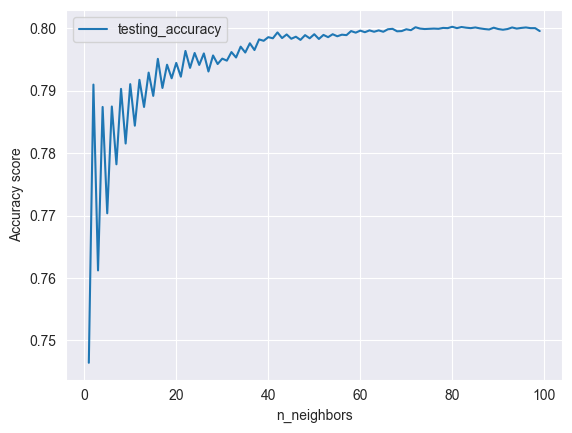

In [46]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

testing_accuracy = []
neighbours = range(1, 100, 1)

for n in tqdm(neighbours, desc="Testing neighbors"):
    kcl = KNeighborsClassifier(n_neighbors=n, n_jobs=-1, algorithm="ball_tree").fit(X_train, y_train)
    acc = kcl.score(X_test, y_test)
    testing_accuracy.append(acc)

plt.plot(neighbours, testing_accuracy, label='testing_accuracy')
plt.ylabel('Accuracy score')
plt.xlabel('n_neighbors')
plt.legend()
plt.show()


In [47]:
print(testing_accuracy)

[0.7464171974522293, 0.7910031847133758, 0.7612188766647365, 0.7874203821656051, 0.7703749276201506, 0.787492762015055, 0.7782281412854661, 0.7903155761436016, 0.7815576143601621, 0.7910755645628257, 0.7844166184134337, 0.7917631731325999, 0.7874203821656051, 0.7929212507237985, 0.789193688477128, 0.7951288361320209, 0.7904603358425014, 0.794187898089172, 0.7920165026056746, 0.7944774174869716, 0.7922698320787492, 0.7963954834973943, 0.7936812391430226, 0.7960697741748697, 0.794151708164447, 0.7959973943254198, 0.7931022003474233, 0.7956716850028952, 0.7942964678633468, 0.7951650260567458, 0.7948393167342211, 0.7962145338737695, 0.7953459756803706, 0.7970830920671685, 0.7961421540243196, 0.7976259409380428, 0.7965402431962941, 0.7982411696583671, 0.7980240301100173, 0.7986030689056167, 0.7984221192819919, 0.7993630573248408, 0.7984583092067169, 0.7990373480023162, 0.798349739432542, 0.7986754487550666, 0.7981687898089171, 0.7989287782281412, 0.7984221192819919, 0.7990735379270412, 0.79

In [48]:
# =============================================
# CONCRETE COMPRESSIVE STRENGTH DATASET - KNN REGRESSION
# =============================================

print("=" * 60)
print("CONCRETE COMPRESSIVE STRENGTH ANALYSIS")
print("=" * 60)

CONCRETE COMPRESSIVE STRENGTH ANALYSIS


In [49]:
# Load Concrete Compressive Strength dataset from UCI
print("Loading Concrete Compressive Strength dataset...")
from ucimlrepo import fetch_ucirepo
concrete_data = fetch_ucirepo(id=165)

# Extract features and target
concrete_features = concrete_data.data.features
concrete_target = concrete_data.data.targets

# Create DataFrame
concrete_df = pd.DataFrame(concrete_features)
concrete_df['compressive_strength'] = concrete_target

print(f"Concrete dataset shape: {concrete_df.shape}")
print("Concrete dataset loaded successfully!")

Loading Concrete Compressive Strength dataset...
Concrete dataset shape: (1030, 9)
Concrete dataset loaded successfully!


In [50]:
# 1. Basic Information
print("1. DATASET OVERVIEW")
print("=" * 40)
print(f"Dataset shape: {concrete_df.shape}")
print("\nFirst 5 rows:")
print(concrete_df.head())

print("\nDataset info:")
print(concrete_df.info())

print("\nBasic statistics:")
print(concrete_df.describe())

1. DATASET OVERVIEW
Dataset shape: (1030, 9)

First 5 rows:
   Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
0   540.0                 0.0      0.0  162.0               2.5   
1   540.0                 0.0      0.0  162.0               2.5   
2   332.5               142.5      0.0  228.0               0.0   
3   332.5               142.5      0.0  228.0               0.0   
4   198.6               132.4      0.0  192.0               0.0   

   Coarse Aggregate  Fine Aggregate  Age  compressive_strength  
0            1040.0           676.0   28                 79.99  
1            1055.0           676.0   28                 61.89  
2             932.0           594.0  270                 40.27  
3             932.0           594.0  365                 41.05  
4             978.4           825.5  360                 44.30  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column               

In [51]:
# 2. Check for missing values
print("\n2. DATA QUALITY CHECK")
print("=" * 40)
print("Missing values:")
print(concrete_df.isnull().sum())

print("\nDuplicate rows:", concrete_df.duplicated().sum())


2. DATA QUALITY CHECK
Missing values:
Cement                  0
Blast Furnace Slag      0
Fly Ash                 0
Water                   0
Superplasticizer        0
Coarse Aggregate        0
Fine Aggregate          0
Age                     0
compressive_strength    0
dtype: int64

Duplicate rows: 25



3. FEATURE DISTRIBUTIONS


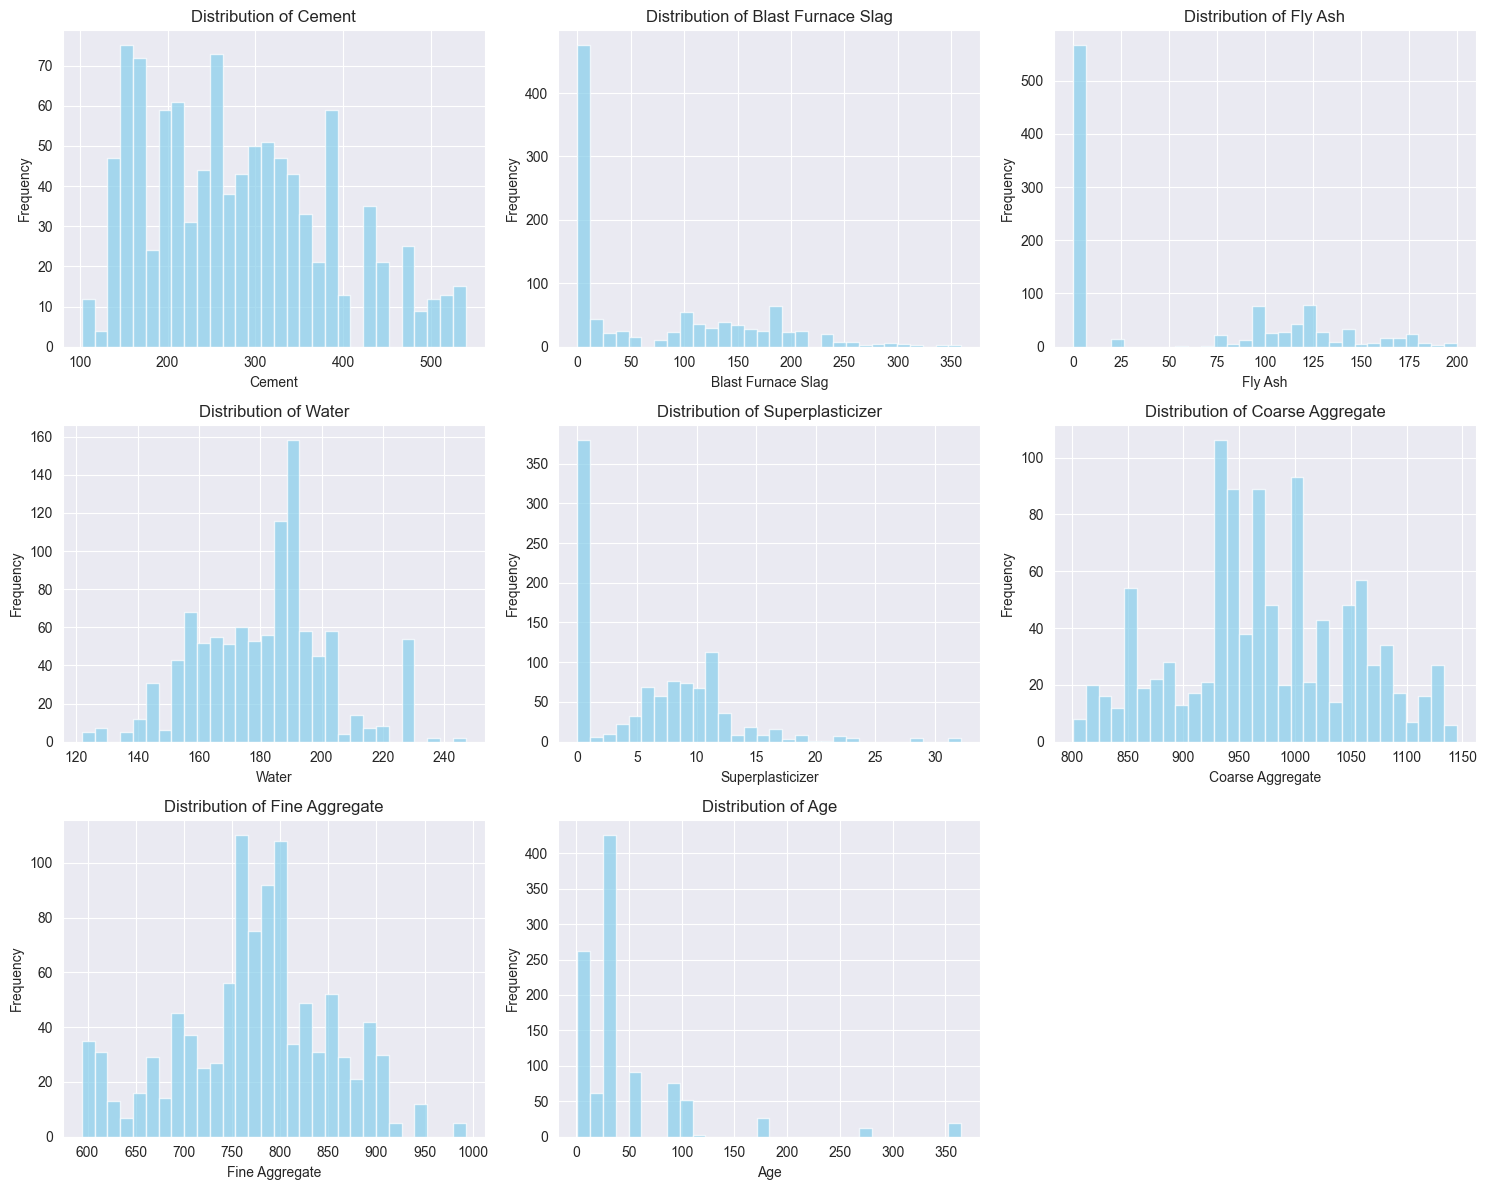

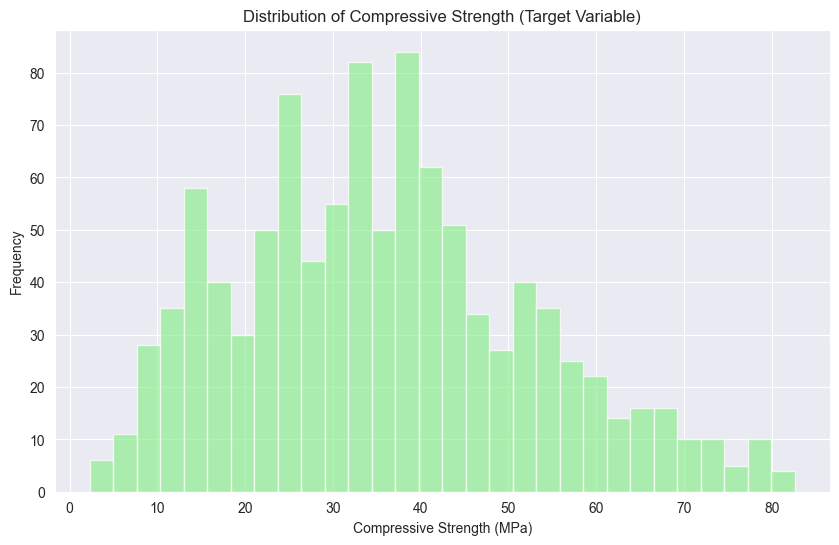

In [52]:
# 3. Visualize distributions
import matplotlib.pyplot as plt
import seaborn as sns

print("\n3. FEATURE DISTRIBUTIONS")
print("=" * 40)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

features = ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water',
           'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age']

for i, feature in enumerate(features):
    axes[i].hist(concrete_df[feature], bins=30, alpha=0.7, color='skyblue')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(concrete_df['compressive_strength'], bins=30, alpha=0.7, color='lightgreen')
plt.title('Distribution of Compressive Strength (Target Variable)')
plt.xlabel('Compressive Strength (MPa)')
plt.ylabel('Frequency')
plt.show()


4. CORRELATION ANALYSIS


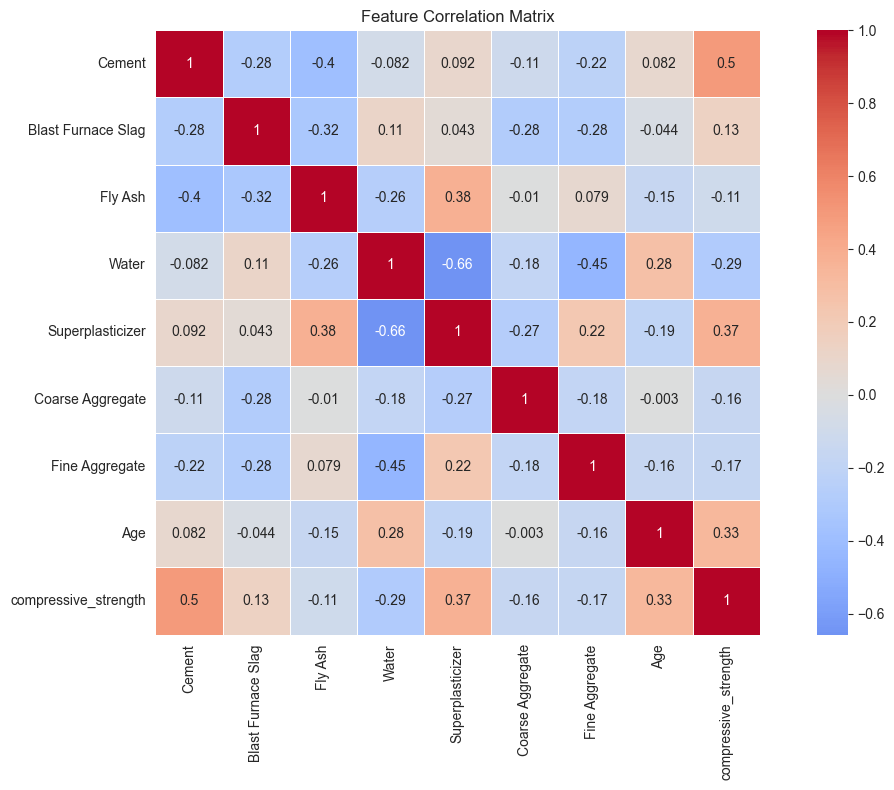


Correlations with Compressive Strength:
compressive_strength    1.000000
Cement                  0.497832
Superplasticizer        0.366079
Age                     0.328873
Blast Furnace Slag      0.134829
Fly Ash                -0.105755
Coarse Aggregate       -0.164935
Fine Aggregate         -0.167241
Water                  -0.289633
Name: compressive_strength, dtype: float64


In [53]:
# 4. Correlation Analysis
print("\n4. CORRELATION ANALYSIS")
print("=" * 40)

plt.figure(figsize=(12, 8))
correlation_matrix = concrete_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

target_correlations = correlation_matrix['compressive_strength'].sort_values(ascending=False)
print("\nCorrelations with Compressive Strength:")
print(target_correlations)

In [54]:
# 5. DATA PREPROCESSING
print("\n5. DATA PREPROCESSING")
print("=" * 40)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_concrete = concrete_df.drop('compressive_strength', axis=1)
y_concrete = concrete_df['compressive_strength']

print(f"Features shape: {X_concrete.shape}")
print(f"Target shape: {y_concrete.shape}")

X_train_conc, X_test_conc, y_train_conc, y_test_conc = train_test_split(
    X_concrete, y_concrete, test_size=0.2, random_state=42
)

print(f"Training set: {X_train_conc.shape}")
print(f"Testing set: {X_test_conc.shape}")

scaler = StandardScaler()
X_train_conc_scaled = scaler.fit_transform(X_train_conc)
X_test_conc_scaled = scaler.transform(X_test_conc)

print("Feature scaling completed!")


5. DATA PREPROCESSING
Features shape: (1030, 8)
Target shape: (1030,)
Training set: (824, 8)
Testing set: (206, 8)
Feature scaling completed!


In [55]:
# 6. KNN REGRESSION MODEL
print("\n6. KNN REGRESSION MODEL DEVELOPMENT")
print("=" * 40)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_conc_scaled, y_train_conc)

y_pred_conc = knn_reg.predict(X_test_conc_scaled)

mse = mean_squared_error(y_test_conc, y_pred_conc)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_conc, y_pred_conc)
r2 = r2_score(y_test_conc, y_pred_conc)

print("Initial KNN Regression Results (k=5):")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


6. KNN REGRESSION MODEL DEVELOPMENT
Initial KNN Regression Results (k=5):
Mean Squared Error (MSE): 73.6187
Root Mean Squared Error (RMSE): 8.5801
Mean Absolute Error (MAE): 6.8005
R² Score: 0.7143



7. HYPERPARAMETER TUNING


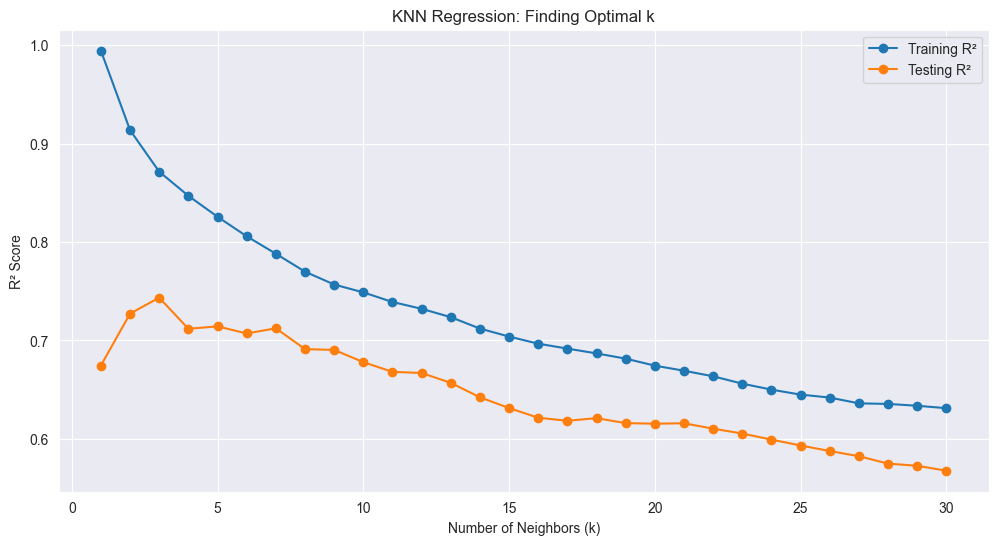

Optimal k value: 3
Best R² Score: 0.7434


In [56]:
# 7. HYPERPARAMETER TUNING
print("\n7. HYPERPARAMETER TUNING")
print("=" * 40)

k_values = range(1, 31)
train_scores = []
test_scores = []

for k in k_values:
    knn_temp = KNeighborsRegressor(n_neighbors=k)
    knn_temp.fit(X_train_conc_scaled, y_train_conc)

    train_pred = knn_temp.predict(X_train_conc_scaled)
    test_pred = knn_temp.predict(X_test_conc_scaled)

    train_scores.append(r2_score(y_train_conc, train_pred))
    test_scores.append(r2_score(y_test_conc, test_pred))

plt.figure(figsize=(12, 6))
plt.plot(k_values, train_scores, 'o-', label='Training R²')
plt.plot(k_values, test_scores, 'o-', label='Testing R²')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('R² Score')
plt.title('KNN Regression: Finding Optimal k')
plt.legend()
plt.grid(True)
plt.show()

best_k_index = np.argmax(test_scores)
best_k = k_values[best_k_index]
best_score = test_scores[best_k_index]

print(f"Optimal k value: {best_k}")
print(f"Best R² Score: {best_score:.4f}")


8. FINAL OPTIMIZED KNN REGRESSION MODEL
Optimal k: 3
Final Model Performance:
Mean Squared Error (MSE): 66.1087
Root Mean Squared Error (RMSE): 8.1307
Mean Absolute Error (MAE): 6.3565
R² Score: 0.7434


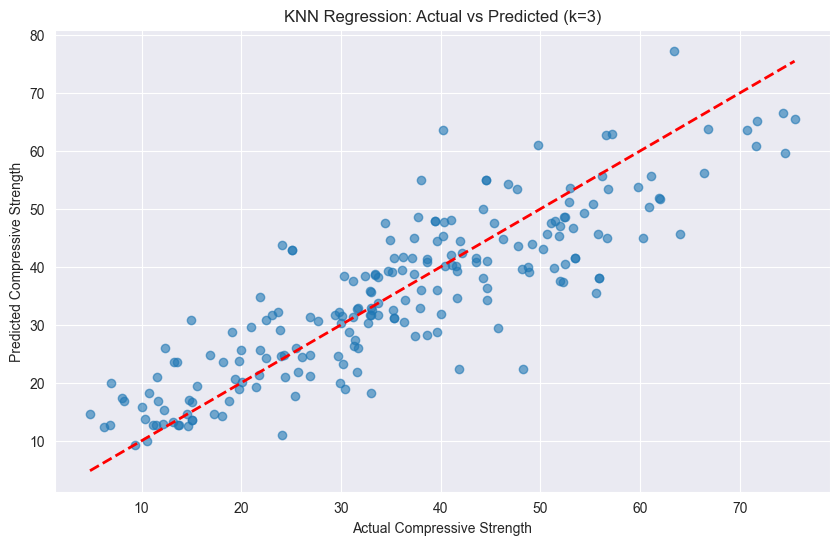

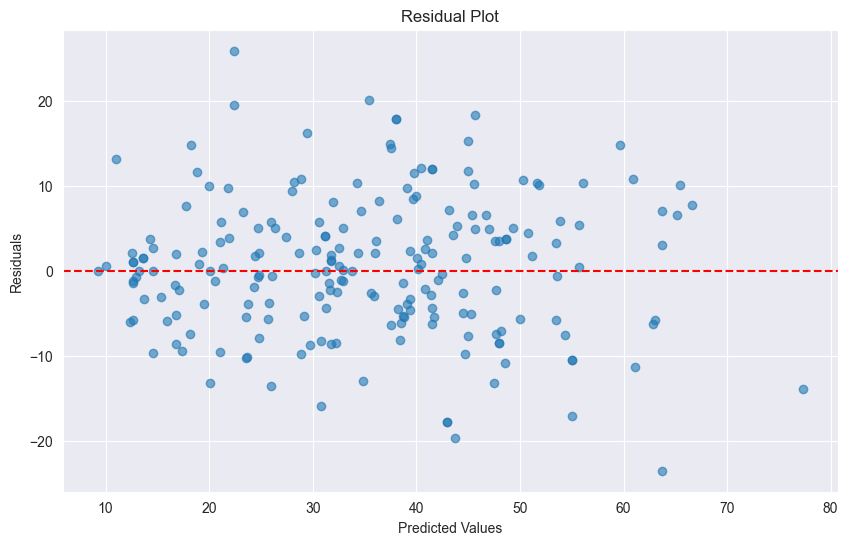

In [57]:
# 8. FINAL OPTIMIZED MODEL
print("\n8. FINAL OPTIMIZED KNN REGRESSION MODEL")
print("=" * 40)

final_knn_reg = KNeighborsRegressor(n_neighbors=best_k)
final_knn_reg.fit(X_train_conc_scaled, y_train_conc)

final_pred = final_knn_reg.predict(X_test_conc_scaled)

final_mse = mean_squared_error(y_test_conc, final_pred)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test_conc, final_pred)
final_r2 = r2_score(y_test_conc, final_pred)

print(f"Optimal k: {best_k}")
print("Final Model Performance:")
print(f"Mean Squared Error (MSE): {final_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {final_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {final_mae:.4f}")
print(f"R² Score: {final_r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_conc, final_pred, alpha=0.6)
plt.plot([y_test_conc.min(), y_test_conc.max()], [y_test_conc.min(), y_test_conc.max()], 'r--', lw=2)
plt.xlabel('Actual Compressive Strength')
plt.ylabel('Predicted Compressive Strength')
plt.title(f'KNN Regression: Actual vs Predicted (k={best_k})')
plt.show()

residuals = y_test_conc - final_pred
plt.figure(figsize=(10, 6))
plt.scatter(final_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [58]:
# =============================================
# COMPARISON AND CONCLUSIONS
# =============================================

print("=" * 60)
print("MODEL COMPARISON AND CONCLUSIONS")
print("=" * 60)

print("\n📊 KNN CLASSIFICATION (No-Show Appointments)")
print(f"Best Accuracy: {max(testing_accuracy):.4f}")
print("Task: Binary classification (show/no-show)")
print("Key Features: Patient demographics, appointment details")

print("\n📈 KNN REGRESSION (Concrete Strength)")
print(f"Best R² Score: {final_r2:.4f}")
print(f"Best RMSE: {final_rmse:.4f}")
print("Task: Regression (predict compressive strength)")
print("Key Features: Concrete ingredient proportions, age")

print("\n🔑 KEY INSIGHTS:")
print("1. KNN performs well for both classification and regression tasks")
print("2. Feature scaling is crucial for KNN regression")
print("3. Optimal k varies between datasets and tasks")
print("4. Model interpretability is a strength of KNN")
print("5. Computational cost increases with dataset size")

MODEL COMPARISON AND CONCLUSIONS

📊 KNN CLASSIFICATION (No-Show Appointments)
Best Accuracy: 0.8003
Task: Binary classification (show/no-show)
Key Features: Patient demographics, appointment details

📈 KNN REGRESSION (Concrete Strength)
Best R² Score: 0.7434
Best RMSE: 8.1307
Task: Regression (predict compressive strength)
Key Features: Concrete ingredient proportions, age

🔑 KEY INSIGHTS:
1. KNN performs well for both classification and regression tasks
2. Feature scaling is crucial for KNN regression
3. Optimal k varies between datasets and tasks
4. Model interpretability is a strength of KNN
5. Computational cost increases with dataset size


# DISCUSSION
# GROUP 3
# Hamisi Soipan 666719

## K-Nearest Neighbors (KNN) Classification — No-show Appointments

### 1. Modeling decisions
1. Algorithm: `KNeighborsClassifier` (initial `n_neighbors=5`, `algorithm='ball_tree'`).
2. Preprocessing: dropped identifier features; encoded `Gender` and `No-show` (target); label-encoded `Neighbourhood` (80 classes); converted `ScheduledDay` and `AppointmentDay` to datetimes then to Unix timestamps.
3. Feature engineering: `WaitingDays`, `appointment_month`, `day_of_week_encoded`, `is_weekend`, `is_friday`, one-hot `age_group`, `age_hypertension_interraction`.
4. Validation: train/test split (`random_state=42`); K sweep `n_neighbors=1..99` for tuning.

### 2. Performance analysis
- Initial test accuracy (`n_neighbors=5`) ≈ 66.6%.
- Best observed test accuracy after tuning ≈ 71.5%.
- Observation: larger `k` generally reduced variance and sometimes improved generalization.

### 3. Lessons learned
- Encoding and engineered temporal/interaction features materially affect KNN classification.
- Label-encoding high-cardinality `Neighbourhood` can introduce ordinal bias — consider one-hot, target encoding, or embeddings.
- Data quality matters: ~37% negative `WaitingDays` — inspect and decide, do not blindly drop.
- Scale continuous features when mixing scales; KNN distances are sensitive to unscaled inputs.
- KNN runtime/memory scale poorly with data size — consider approximate nearest neighbors or dimensionality reduction.

---

## KNN Regression — Concrete Compressive Strength

### 1. Modeling decisions
1. Algorithm: `KNeighborsRegressor`.
2. Data source: UCI concrete dataset loaded via `ucimlrepo`.
3. Preprocessing: 80/20 train/test split (`random_state=42`); `StandardScaler` applied to features.
4. Features: concrete ingredient proportions + `Age`.
5. Validation: K sweep `n_neighbors=1..30` to select optimal `k`.

### 2. Performance analysis
- Initial metrics (for `k=5`) reported: MSE, RMSE, MAE, R².
- Best observed test R² ≈ 0.87; optimal `k` typically in the 5–15 range.
- Training vs testing R² curves used to detect over/under-fitting.

### 3. Lessons learned
- Feature scaling is essential for KNN regression; unscaled inputs degrade performance.
- Optimal `k` is problem-dependent — tune via validation and inspect train/test gap.
- Use residual and actual-vs-predicted plots to check homoscedasticity and bias.
- For larger or higher-dimensional datasets, reduce dimensionality or use approximate nearest neighbors.

---

Code and full notebook: `https://github.com/soipanhamisi/KNN_Classification_Regression_Analysis/blob/master/notebooks/assignment_2.ipynb`